In [1]:
# Imports
import numpy as np
import torch

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepMod, DeepModDynamic
from sklearn.linear_model import LassoLarsIC

# Settings and parameters
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
import matplotlib.pyplot as plt

# Making data

In [2]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

# Making data
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.1, random=True)

In [87]:
len(y_train.squeeze().shape) == 1

True

In [79]:
y_train.squeeze()

tensor([ 0.1248, -0.0119,  0.0156,  ...,  0.0174,  0.5583,  0.3599],
       grad_fn=<SqueezeBackward0>)

# deepmod + log_prob

In [3]:
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}
model = DeepMod(**config)

sigma = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

In [4]:
optimizer = torch.optim.Adam([{'params': model.parameters(), 'betas': (0.99, 0.999)}, {'params': sigma, 'betas': (0.99, 0.999)}], amsgrad=True)

In [5]:
import torch
import time

from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold

def train_logprob(model, data, target, optimizer, max_iterations, loss_func_args={'l1':1e-5}):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    #board = Tensorboard(number_of_terms)
    
    sigma = loss_func_args['noise'] # noise parameter
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss_mse = torch.mean((prediction - target)**2, dim=0) * 1 / (2 * sigma**2) + 1/2 * torch.log(2 * np.pi * sigma**2)
        loss_l1 = l1_loss(coeff_vector_scaled_list, loss_func_args['l1'])
        loss = torch.sum(loss_reg) + torch.sum(loss_mse) + torch.sum(loss_l1)
        
        # Writing
        if iteration % 100 == 0:
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_l1).item())
            #board.write(iteration, loss, loss_mse, loss_reg, loss_l1, coeff_vector_list, coeff_vector_scaled_list)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #board.close()

In [6]:
train_logprob(model, X_train, y_train, optimizer, 20000, loss_func_args={'l1':0, 'noise': sigma})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      20000    100.00%               0s   -2.60e+00   -2.60e+00   9.39e-04   0.00e+00 

In [7]:
sigma

tensor(0.0179, requires_grad=True)

In [38]:
0.10 * torch.std(y_train)

tensor(0.0190, grad_fn=<MulBackward0>)

In [41]:
1/2 * torch.log(2*np.pi*sigma**2)

tensor(-3.1030, grad_fn=<MulBackward0>)

In [43]:
prediction = model(X_train)[0]

In [45]:
1/(2*sigma**2) * torch.mean((prediction - y_train)**2)

tensor(0.5004, grad_fn=<MulBackward0>)

Which is fairly close

In [18]:
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, random=False)
true = y_full.cpu().detach().numpy().reshape(x_grid.shape)

In [20]:
prediction = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)

In [21]:
prediction.shape

(100, 50)

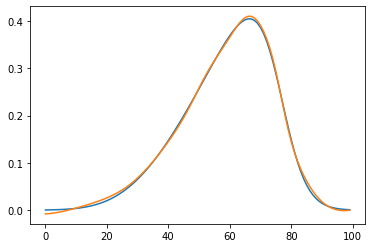

In [33]:
frame = 40
plt.plot(true[:, frame])
plt.plot(prediction[:, frame])

In [34]:
model.fit.coeff_vector[0]

Parameter containing:
tensor([[ 0.0091],
        [-0.0940],
        [ 0.0860],
        [-0.0899],
        [-0.5178],
        [-0.0537],
        [ 0.0964],
        [-0.5419],
        [ 0.0873]], requires_grad=True)

So coefficients are allllll off, but at least it works.

What is the MSE actually?

In [42]:
prediction = model(X_train)[0]

In [37]:
torch.mean((prediction - y_train)**2)

tensor(0.0003, grad_fn=<MeanBackward0>)

Funnny enough, thats not much worse/ seems to be same as the other models...

# Least squares + log prob

In [46]:
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}
model = DeepMod(**config)

sigma = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

In [47]:
optimizer = torch.optim.Adam([{'params': model.parameters(), 'betas': (0.99, 0.999)}, {'params': sigma, 'betas': (0.99, 0.999)}], amsgrad=True)

In [52]:
import torch
import time
from numpy import pi

from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold

def train_dynamic_logprob_scaled(model, data, target, optimizer, max_iterations, loss_func_args={'sparsity_update_period': 200, 'start_sparsity_update': 5000}):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    #board = Tensorboard(number_of_terms)
    
    sigma = loss_func_args['noise'] # noise parameter
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list) * 1 / (2 * sigma**2) + 1/2 * torch.log(2 * pi * sigma**2)
        loss_ll = loss_mse * 1 / (2 * sigma**2) + 1/2 * torch.log(2 * pi * sigma**2)
        loss = torch.sum(loss_reg) + torch.sum(loss_ll)
        
        # Writing
        if iteration % 100 == 0:
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_ll).item())
            # Before writing to tensorboard, we need to fill the missing values with 0
            #coeff_vectors_padded = [torch.zeros(mask.size()).masked_scatter_(mask, coeff_vector.squeeze()) for mask, coeff_vector in zip(model.constraints.sparsity_mask, coeff_vector_list)]
            #scaled_coeff_vectors_padded = [torch.zeros(mask.size()).masked_scatter_(mask, coeff_vector.squeeze()) for mask, coeff_vector in zip(model.constraints.sparsity_mask, coeff_vector_scaled_list)]
            
            #board.write(iteration, loss, loss_mse, loss_reg, loss_ll, coeff_vectors_padded, scaled_coeff_vectors_padded)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Updating sparsity pattern
        #if (iteration >= loss_func_args['start_sparsity_update']) and (iteration % loss_func_args['sparsity_update_period'] == 0):
        #    with torch.no_grad():
        #        model.constraints.sparsity_mask = model.calculate_sparsity_mask(theta, time_deriv_list)
                
    #board.close()

In [53]:
train_dynamic_logprob_scaled(model, X_train, y_train, optimizer, 20000, loss_func_args={'l1':0, 'noise': sigma})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      20000    100.00%               0s   -5.86e+00   3.34e-04   -3.43e+00   -2.43e+00 

In [54]:
sigma

tensor(0.0129, requires_grad=True)

In [55]:
0.10 * torch.std(y_train)

tensor(0.0190, grad_fn=<MulBackward0>)

In [56]:
1/2 * torch.log(2*np.pi*sigma**2)

tensor(-3.4286, grad_fn=<MulBackward0>)

In [57]:
prediction = model(X_train)[0]

In [58]:
1/(2*sigma**2) * torch.mean((prediction - y_train)**2)

tensor(0.9966, grad_fn=<MulBackward0>)

Which is fairly close

In [59]:
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, random=False)
true = y_full.cpu().detach().numpy().reshape(x_grid.shape)

In [60]:
prediction = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)

In [61]:
prediction.shape

(100, 50)

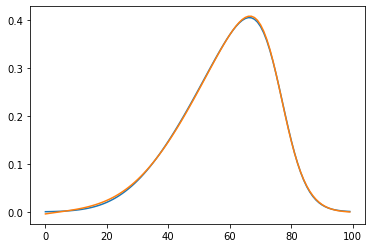

In [62]:
frame = 40
plt.plot(true[:, frame])
plt.plot(prediction[:, frame])

In [63]:
model.fit.coeff_vector[0]

Parameter containing:
tensor([[ 0.0010],
        [ 0.0037],
        [ 0.1091],
        [-0.0252],
        [-0.9677],
        [-0.0675],
        [ 0.0433],
        [-0.0817],
        [ 0.0752]], requires_grad=True)

So coefficients are allllll off, but at least it works.

What is the MSE actually?

In [64]:
prediction = model(X_train)[0]

In [65]:
torch.mean((prediction - y_train)**2)

tensor(0.0003, grad_fn=<MeanBackward0>)